In [5]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'pascalvoc'
s3_train_data = 's3://{}/{}/input/train'.format(bucket, prefix)
s3_validation_data = 's3://{}/{}/input/validation'.format(bucket, prefix)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [6]:
from sagemaker.image_uris import retrieve
region = sess.boto_region_name
container = retrieve('object-detection', region)

In [7]:
od = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    output_path=s3_output_location
)

In [33]:
sagemaker.get_execution_role()

'arn:aws:iam::829135631045:role/service-role/AmazonSageMaker-ExecutionRole-20220831T162722'

In [8]:
od.set_hyperparameters(
    base_network='resnet-50',
    use_pretrained_model=1,
    num_classes=20,
    num_training_samples=16551,
    epochs=30
)

In [10]:
from sagemaker.session import TrainingInput
train_data = TrainingInput(
    s3_train_data,
    content_type='application/x-recordio'
)
validation_data = TrainingInput(
      s3_validation_data, 
      content_type='application/x-recordio'
)
data_channels = {
    'train': train_data, 
    'validation': validation_data
}

In [11]:
od.fit(inputs=data_channels)

2022-09-11 02:58:13 Starting - Starting the training job...ProfilerReport-1662865093: InProgress
...
2022-09-11 02:58:56 Starting - Preparing the instances for training.........
2022-09-11 03:00:37 Downloading - Downloading input data...
2022-09-11 03:01:07 Training - Downloading the training image............
2022-09-11 03:03:13 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[09/11/2022 03:03:19 INFO 139788198278976] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'base_network': 'vgg-16', 'use_pretrained_model': '0', 'num_classes': '', 'mini_batch_size': '32', 'epochs': '30', 'learning_rate': '0.001', 'lr_scheduler_step': '', 'lr_scheduler_factor': '0.1', 'optimizer': 'sgd', 'momentum': '0.9', 'weight_decay': '0.0005', 'overlap_threshold': '0.5', 'nms_threshold':

In [13]:
od_predictor = od.deploy(
    initial_instance_count = 1,
    instance_type='ml.c5.2xlarge'
)

--------!

In [16]:
od_predictor.__dict__

{'endpoint_name': 'object-detection-2022-09-11-05-13-47-109',
 'sagemaker_session': <sagemaker.session.Session at 0x7fdd4fd3d190>,
 'serializer': <sagemaker.serializers.IdentitySerializer at 0x7fdd5079f850>,
 'deserializer': <sagemaker.deserializers.BytesDeserializer at 0x7fdd5079f890>,
 '_endpoint_config_name': None,
 '_model_names': None,
 '_context': None}

In [17]:
import boto3, json
with open('test.jpg', 'rb') as image:
    payload = image.read()
    payload = bytearray(payload)
client = boto3.client('sagemaker-runtime')
response = client.invoke_endpoint(
    EndpointName=od_predictor.endpoint_name,
    Body=payload,
    ContentType='application/x-image',
)

In [18]:
response

{'ResponseMetadata': {'RequestId': 'd683ebc0-fbe2-434f-adbe-14290e0999e3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd683ebc0-fbe2-434f-adbe-14290e0999e3',
   'x-amzn-invoked-production-variant': 'AllTraffic',
   'date': 'Sun, 11 Sep 2022 05:40:14 GMT',
   'content-type': 'application/json',
   'content-length': '12764'},
  'RetryAttempts': 0},
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'Body': <botocore.response.StreamingBody at 0x7fdd4faea190>}

In [19]:
repsone_image = json.loads(response['Body'].read())

In [28]:
repsone_image

{'prediction': [[7.0,
   0.47139865159988403,
   0.12565794587135315,
   0.10802081227302551,
   0.8905231952667236,
   0.9168107509613037],
  [11.0,
   0.041131045669317245,
   0.44100522994995117,
   0.04929894208908081,
   0.8804148435592651,
   0.6459264755249023],
  [2.0,
   0.023541290313005447,
   0.06920225918292999,
   0.22389203310012817,
   0.2098112851381302,
   0.3765408992767334],
  [16.0,
   0.02154647558927536,
   0.180120587348938,
   0.13027220964431763,
   0.8275012969970703,
   0.8640247583389282],
  [2.0,
   0.021288393065333366,
   0.09394953399896622,
   0.25346094369888306,
   0.27061572670936584,
   0.4249802231788635],
  [2.0,
   0.0207358431071043,
   0.09257541596889496,
   0.22963930666446686,
   0.16724048554897308,
   0.34784024953842163],
  [8.0,
   0.019911520183086395,
   0.16037538647651672,
   0.6263853311538696,
   0.30690252780914307,
   0.7963359355926514],
  [2.0,
   0.019785795360803604,
   0.10798252373933792,
   0.19871625304222107,
   0.16137

repsone_image

In [29]:
def plot_detection(img_file, dets, classes=[], thresh=0.6):
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

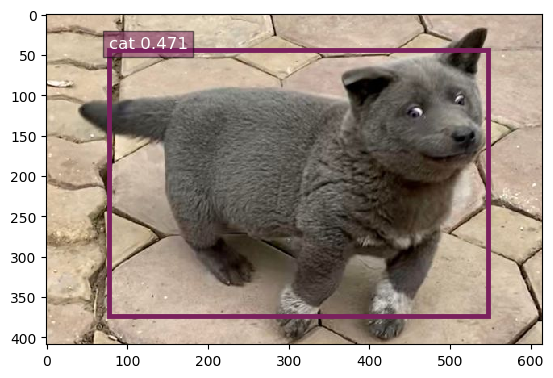

In [30]:
%matplotlib inline 

object_categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
                     'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
                     'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.30

# Visualize the detections.
plot_detection('test.jpg', repsone_image['prediction'], object_categories, threshold)

In [27]:
od_predictor.delete_endpoint()